![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in Deep Learning-Based Signal Analysis: The Class Activation Map (CAM)

In this Notebook, we will delve into the utilization of CAM to reveal the sections of a signal that a ResNet-50 model trained on signal data considers crucial during its prediction process.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/Juelich-2023/xai-model-for-1d-data/Tutorial_CAM_for_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2023 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-model-for-1d-data

## Imports, data and model loading

In [1]:
%matplotlib inline
import sys 
import shutil 
import warnings
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

sys.path.append('../data_and_models/ECG')
from ResNet1D import ResNet, ResNetBlock
from ECG import ECG

warnings.filterwarnings("ignore")

We fix the random seeds to ensure reproducible results as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

Let's first download the dataset.

In [3]:
dataset_path = "../data_and_models/ECG/data/"

In [6]:
!mkdir ../data_and_models/ECG/data
!curl -L "https://www.dropbox.com/scl/fi/jdx1cf8gbftiuptso7od1/Dataset_ECG.zip?rlkey=vtfz13r1rpzfsgpd4vghjmpdy&dl=0" > ../data_and_models/ECG/data/Dataset_ECG.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    329      0 --:--:-- --:--:-- --:--:--   329
100   491    0   491    0     0    390      0 --:--:--  0:00:01 --:--:--  1067
100 97.9M  100 97.9M    0     0  17.9M      0  0:00:05  0:00:05 --:--:-- 26.6M


In [7]:
shutil.unpack_archive(dataset_path + "Dataset_ECG.zip", dataset_path)
shutil.rmtree(dataset_path + '__MACOSX')

Let's set some paths. We provide the path of the model's weight and the location of the test data. 

In [6]:
model_weights_path = '../data_and_models/ECG/weights/model_final_weights_ecg.pth'
test_data_path = '../data_and_models/ECG/data/Dataset_ECG/mitbih_test.csv'

We have trained a modified version of ResNet-50 model for 10 epochs on the Electrocardiogram (ECG) Heartbeat Categorization Dataset. The original ResNet-50 architecture typically employs 2D convolutional layers (conv2d) as it is primarily designed for processing 2D data, such as images. However, when adapting ResNet-50 for 1D data, such as time-series or audio data, the architecture is modified to use 1D convolutional layers (conv1d) instead. This modification is essential to make the network suitable for analyzing 1D data, as the conv1d layers are specifically designed to process data that has only one spatial dimension.

The dataset is made up of two groups of heartbeat signals, originating from two well-known heartbeat classification datasets - the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. We used the MIT-BIH Arrhythmia Dataset to train our model. This dataset consists of 87554 samples for train, 21892 samples for test, and 5 categories (['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4])

The dataset is organized in CSV files. Inside every CSV file, there's a matrix structure. Each row in the matrix signifies an individual ECG signal instance. The last column in each row determines the specific category the example belongs to. For more details about the dataset, please refer to [1].

The model on test data shows a high accuracy of 99.44% and a low average loss of 0.0009. The F1 scores, which are the harmonic mean of precision and recall, are 99.30%, 83.83%, 96.60%, 84.57%, and 99.03% for the classes N, S, V, F, and Q, respectively. These scores suggest a balanced performance between precision and recall, with the second and fourth classes showing slightly lower F1 scores. 

If you want to know more about the training and the inference results, please check the files under the folder "data_and_models/ECG"

Consequently, we have created an ECG class that loads the dataset.

In [7]:
ecg = ECG(test_data_path)

Now, let's load our trained model.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(ResNetBlock, [2, 2, 2, 2], num_classes=5)
model = model.to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device=device)))

<All keys matched successfully>

## Generating a Class Activation Map (CAM)

To generate a Class Activation Map (CAM) in a Convolutional Neural Network (CNN), we follow a series of steps, and the figure below provides a clear summary of these steps.

<img src="..//docs/source/_figures/1dcam.png" alt="Image Title" width="800" height="500">

#### Step 1: Train the model

First, we train our model. CAM works with CNN architectures incorporating a Global Average Pooling (GAP) layer before the final classification layer. The CNN processes the input signal through its convolutional layers, resulting in a set of feature maps at the end of these layers. The architecture should look like this:

- Convolutional layers
- Global Average Pooling (GAP)
- Fully connected layer (FC)

#### Step 2: Forward Pass

Once the model is trained, we can generate our cam. We perform a forward pass with the input signal through the network. Obtain the feature maps from the last convolutional layer. Denote these feature maps as $ f_k(x, y) $, where $ k $ is the index of the feature map, and $ (x, y) $ are spatial coordinates.

#### Step 3: Obtain the Weights

The GAP layer takes these feature maps and reduces each one to a single average value, creating a one-dimensional vector where each value corresponds to a channel in the feature map.

This vector is then fed into a fully connected layer that makes the final class predictions. This layer has weights that we extract. The weight corresponding to class $ c $ for feature map $ k $ is denoted as $ w_k^c $.

#### Step 4: Compute the Class Activation Map

Compute the CAM for a specific class $ c $ using the formula:

$
CAM_c(x, y) = \sum_k w_k^c \cdot f_k(x, y)
$

This formula calculates the CAM as a weighted sum of the feature maps, where the weights are specific to the class $ c $.

#### Step 5: Post-processing

- Resize the CAM to match the size of the input signal.
- Apply a heatmap or color map for better visualization.
- Overlay the CAM on the original signal to identify the regions most relevant for the specific class.

The CAM highlights areas in the input signal that are significant for CNN's prediction of class $ c $, providing insights into what the network 'sees' as important for its decision-making.

In our scenario, the ResNet-50 architecture comprises a series of convolutional layers, succeeded by GAP, a fully connected layer, and a softmax layer. Given this setup, we can generate our CAM.

We create the `return_cam` function that generates a CAM for a specific input and class label using our trained ResNet-50.
The function proceeds as follows:

1. The model processes the input `x`, returning two outputs: `conv_map`, the feature maps from the last convolutional layer, and `logits`, the class scores (before softmax activation).
2. We then create a copy of the feature maps, ensuring they do not impact the computational graph's gradients.
3. Then, we extract weights from the model's fully connected layer `fc`, specifically those associated with the `label`. These weights are crucial for determining the important parts of the feature maps for the specified class.
4. Next, the function reshapes `cam_weights` to align with the dimensions of the feature maps. It then multiplies these reshaped weights with `feature_map`. Following this, the function computes the weighted sum across the feature maps. This operation yields a 2D tensor where the first axis has a dimension of 1, which is the CAM. The CAM effectively highlights regions important for predicting the specified class.
5. Finally, we return the generated CAM and logits. 

In [9]:
def return_cam(model, x, label):
    logits, conv_map = model(x)
    feature_map = conv_map.detach().clone()
    cam_weights = model.fc.weight[label]
    cam = (cam_weights.view(*feature_map.shape[:2], 1) *
        feature_map).mean(1, keepdim=False)

    return cam, logits

We code some utility functions—the normalize_scoremap function to normalize the CAM and the t2n function to transform a numpy array to a tensor.

We also have a function named plot_cam that takes the cam and the signal to plot them in a single figure. The code line uses Matplotlib's `imshow` to display a CAM with a red color map (`cmap='Reds'`) over a signal plot. The aspect ratio is set to 'auto' to fit the image to the axes, and `extent` aligns the CAM's dimensions with the signal's length and value range. The CAM is fully opaque (`alpha=1.0`), providing a clear overlay to highlight regions in the signal that are influential for the model's predictions. 

In [10]:
def normalize_scoremap(cam):
    if np.isnan(cam).any():
        return np.zeros_like(cam)
    if cam.min() == cam.max():
        return np.zeros_like(cam)

    cam -= cam.min()
    cam /= cam.max()
    return cam

def t2n(t):
    return t.detach().cpu().numpy().astype(float)

def plot_cam(cam, signal):
    fig, axs = plt.subplots(figsize=(25,5))
    pcm = axs.imshow(cam, cmap='Reds',  aspect="auto", \
        extent=[0, len(signal[0]), math.floor(signal[0].min()), math.ceil(signal[0].max())], alpha=1.0)
    axs.plot(signal[0], 'k')
    fig.colorbar(pcm, ax=axs, shrink=0.6)
    plt.show()

Let's generate the 5 CAMs for each class in the test set. Once the CAM is generated, we resize it to the same size as the original signal and normalize the values. We then plot the result.

In [11]:
def get_prediction(idx):
    samples = ecg[idx]
    signal = samples[0]
    label = samples[1]

    # We unsqueeze the signal to add a batch dimension
    cam, _ = return_cam(model, signal.unsqueeze(0).to(device), label)
    cam = t2n(cam)

    cam_resized = cv2.resize(cam, (signal.shape[-1], 1), interpolation=cv2.INTER_CUBIC)
    cam_normalized = normalize_scoremap(cam_resized)  

    plot_cam(cam_normalized, signal)
    

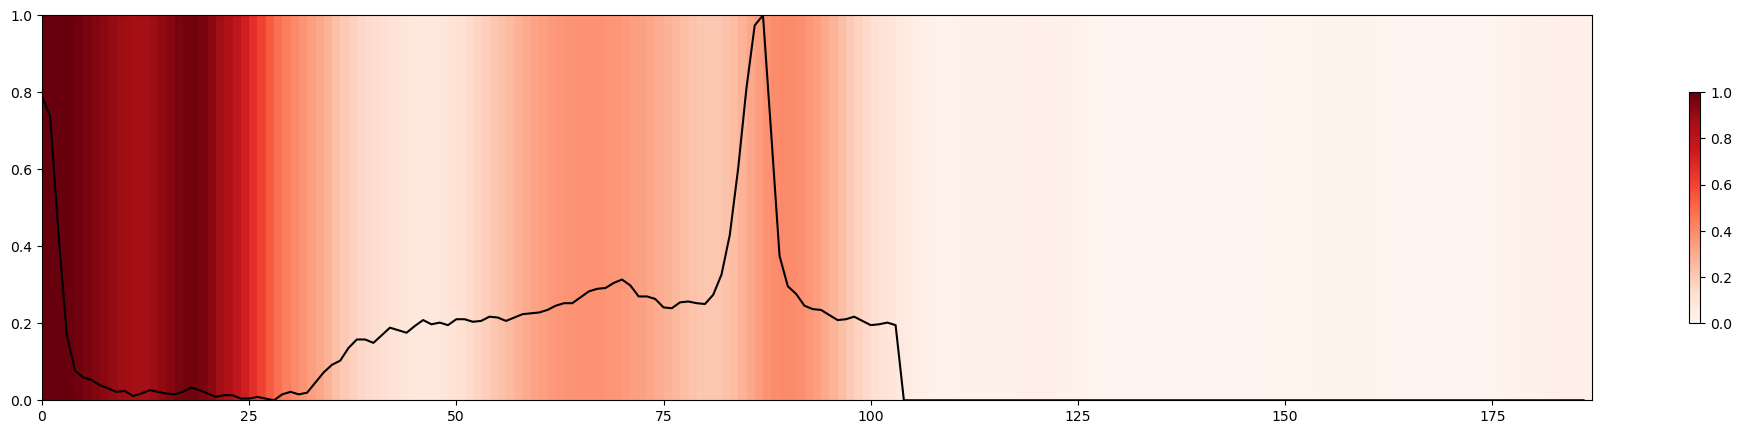

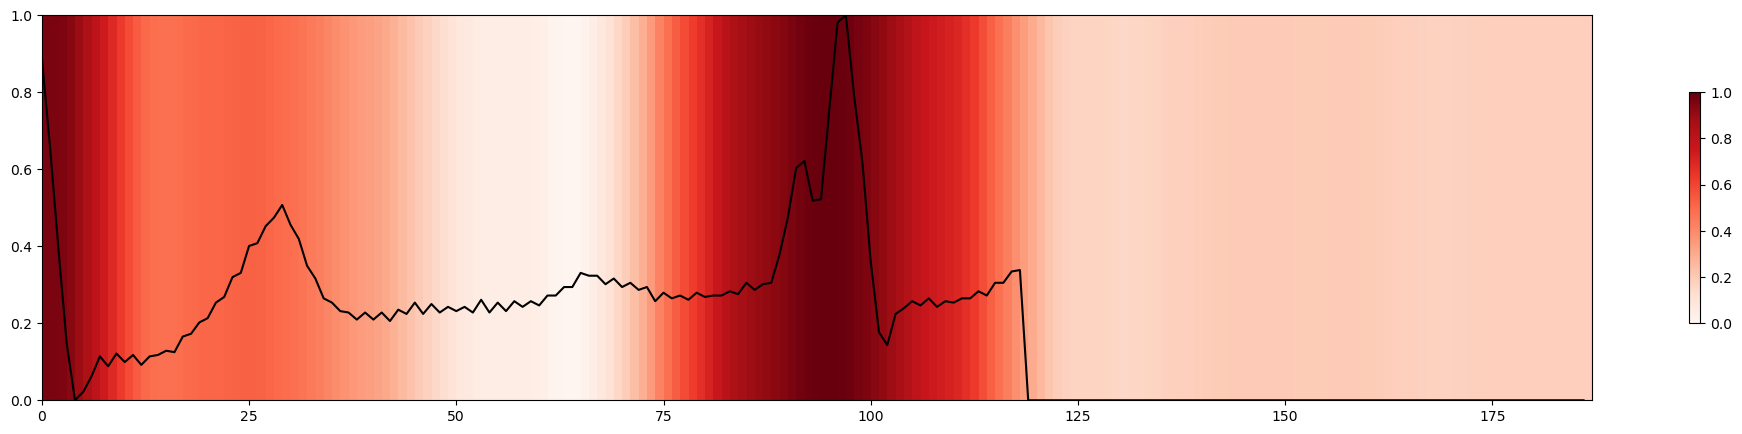

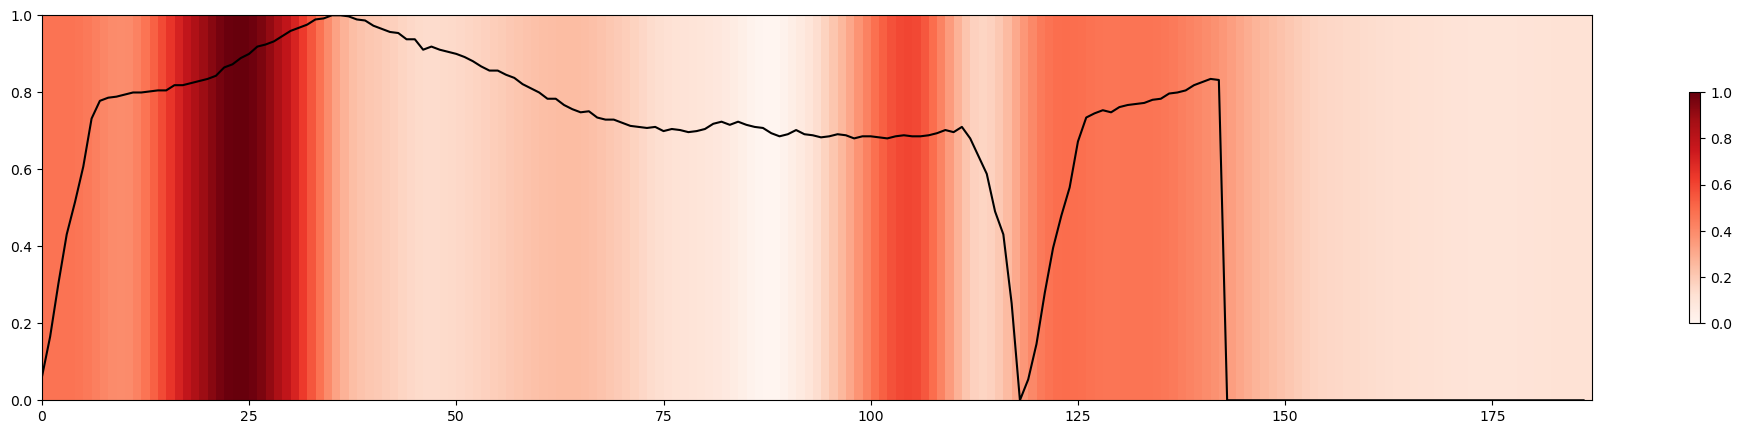

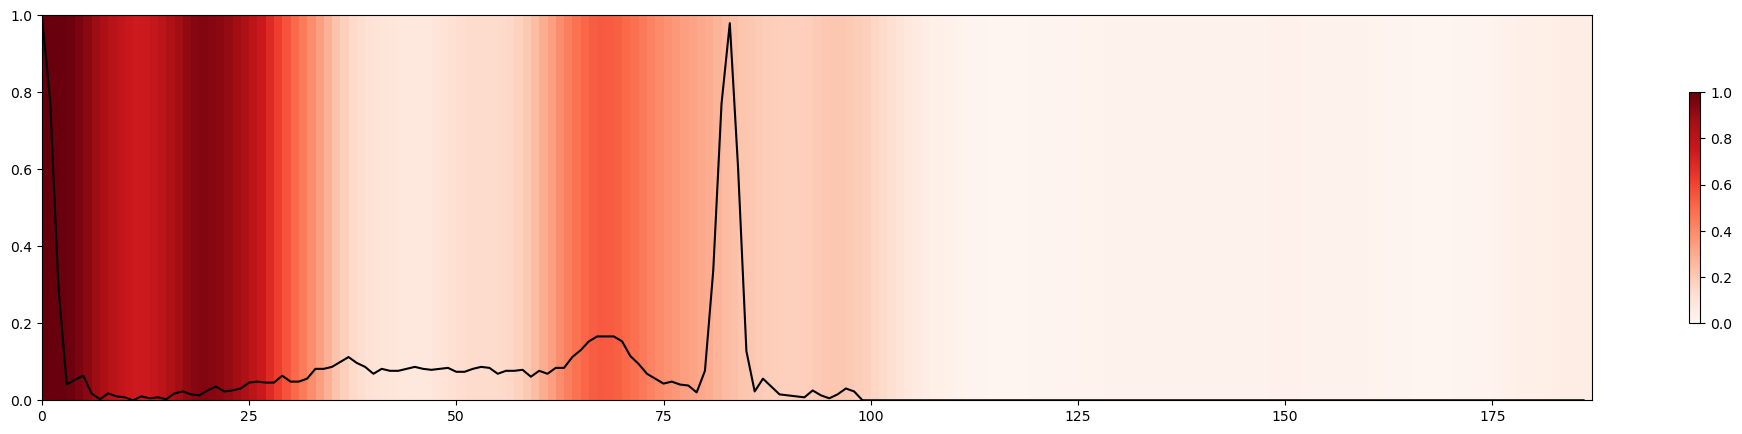

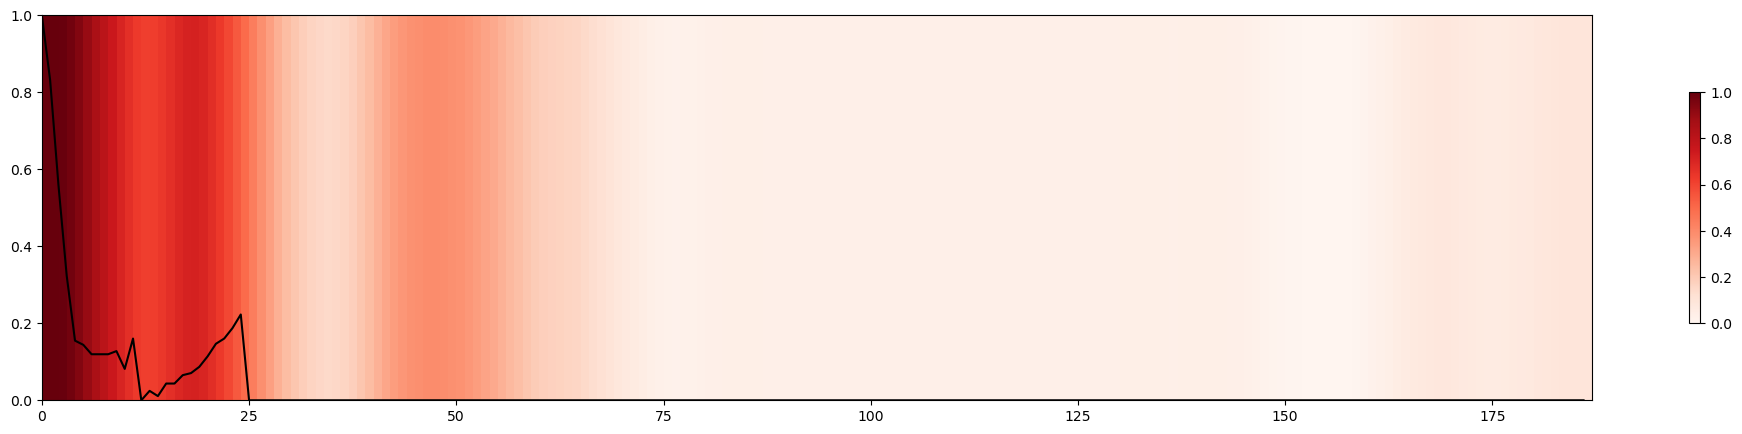

In [12]:
# CAMs that belongs to class N 
for i in range(2000,2005):
  get_prediction(i)

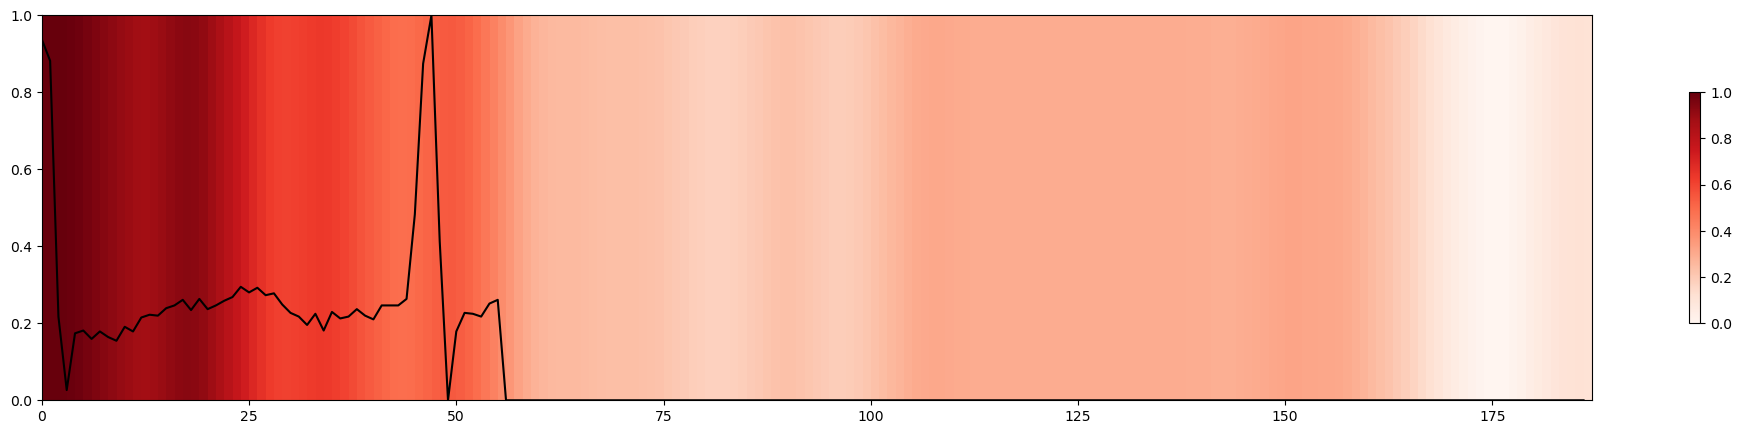

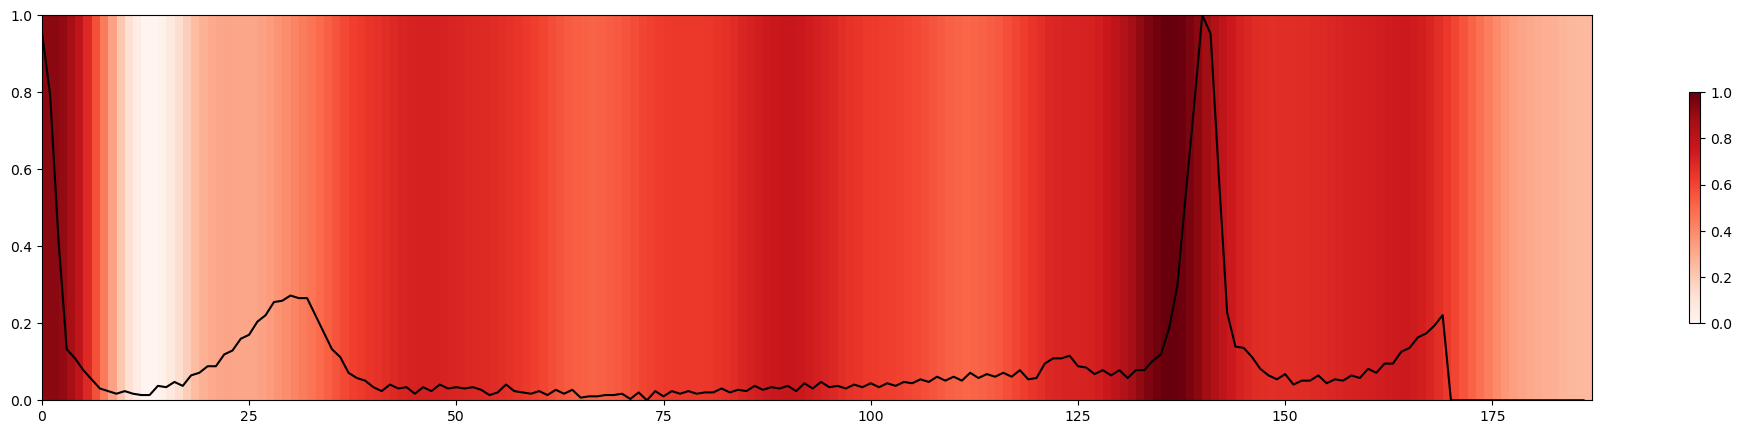

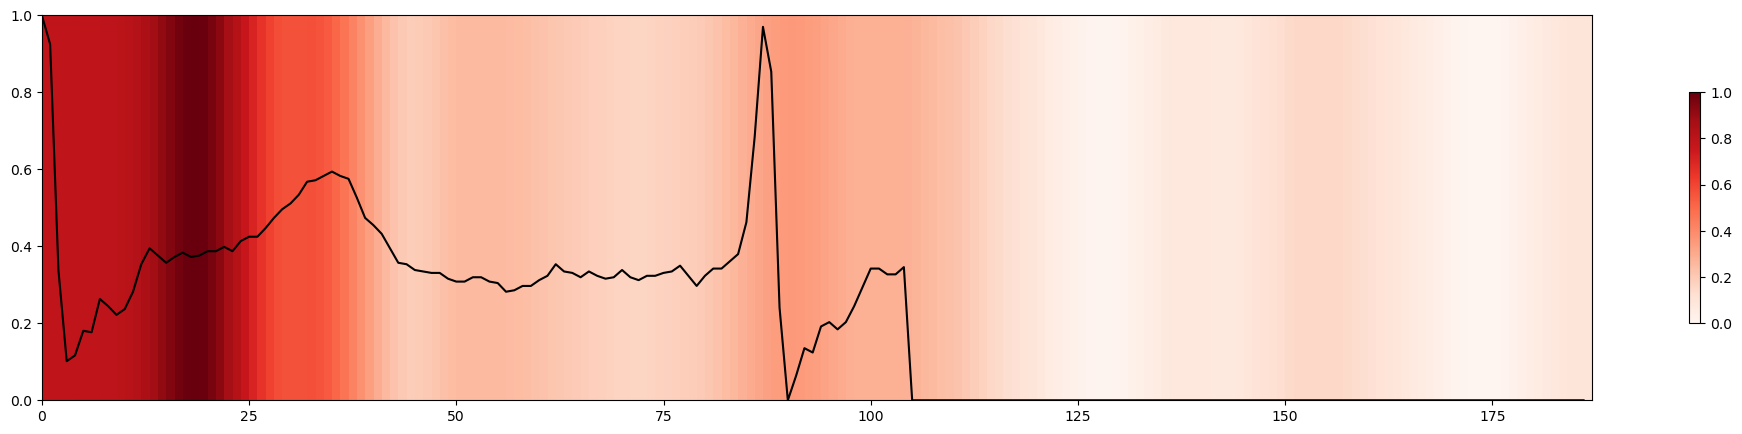

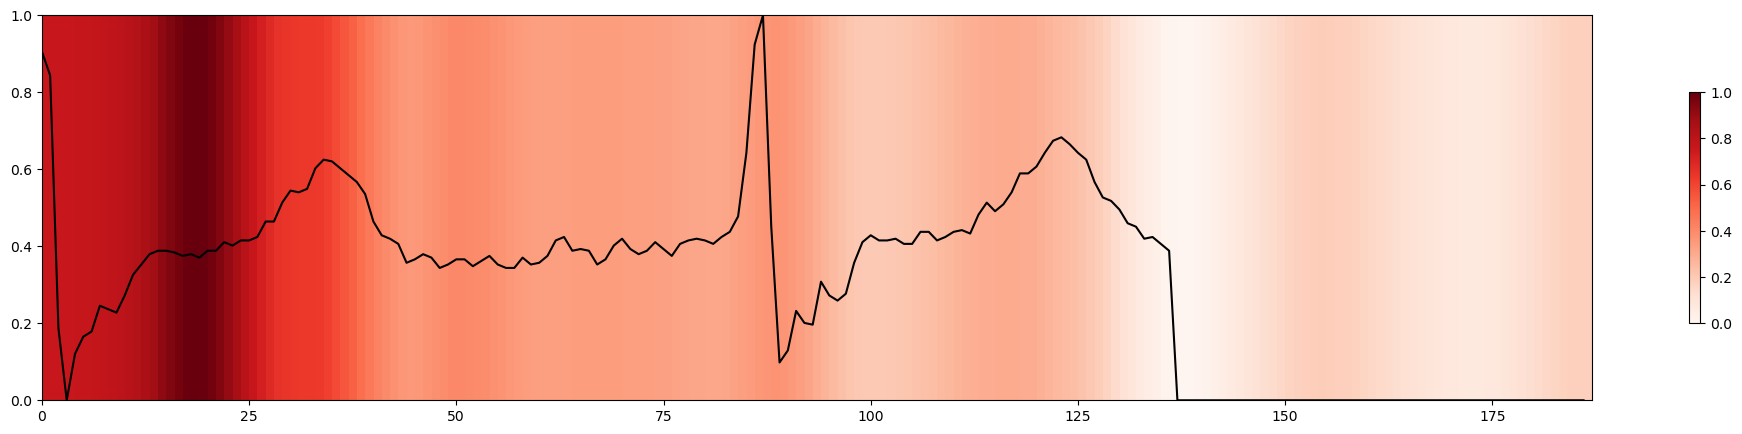

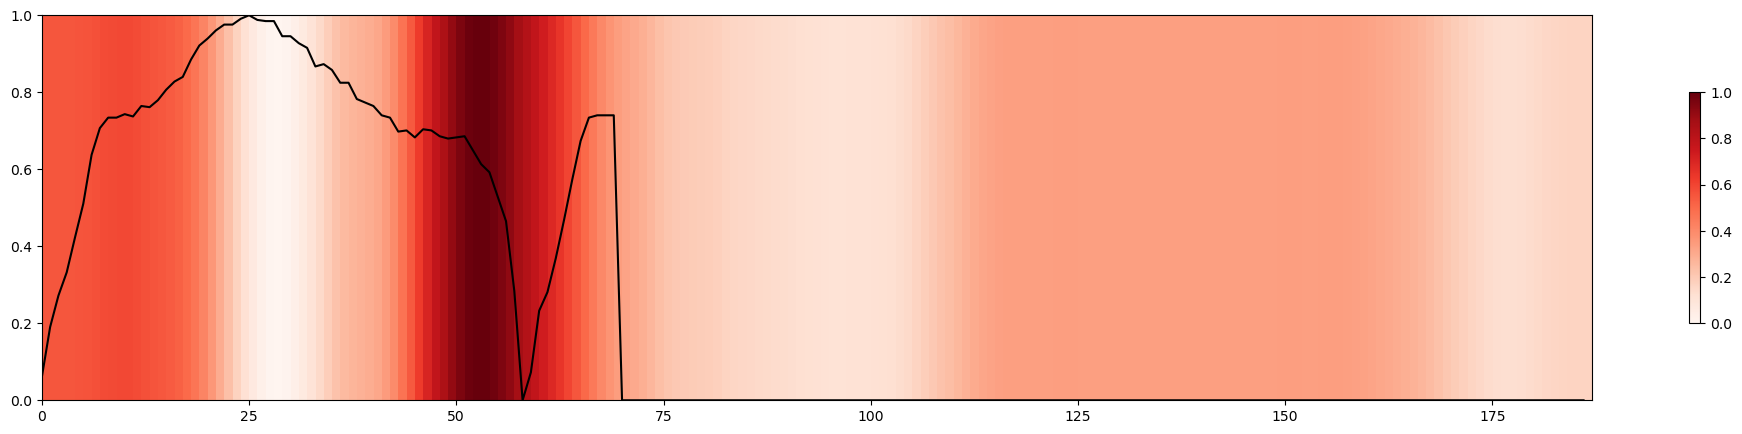

In [13]:
# CAMs that belongs to class S 
for i in range(18150,18155):
  get_prediction(i)

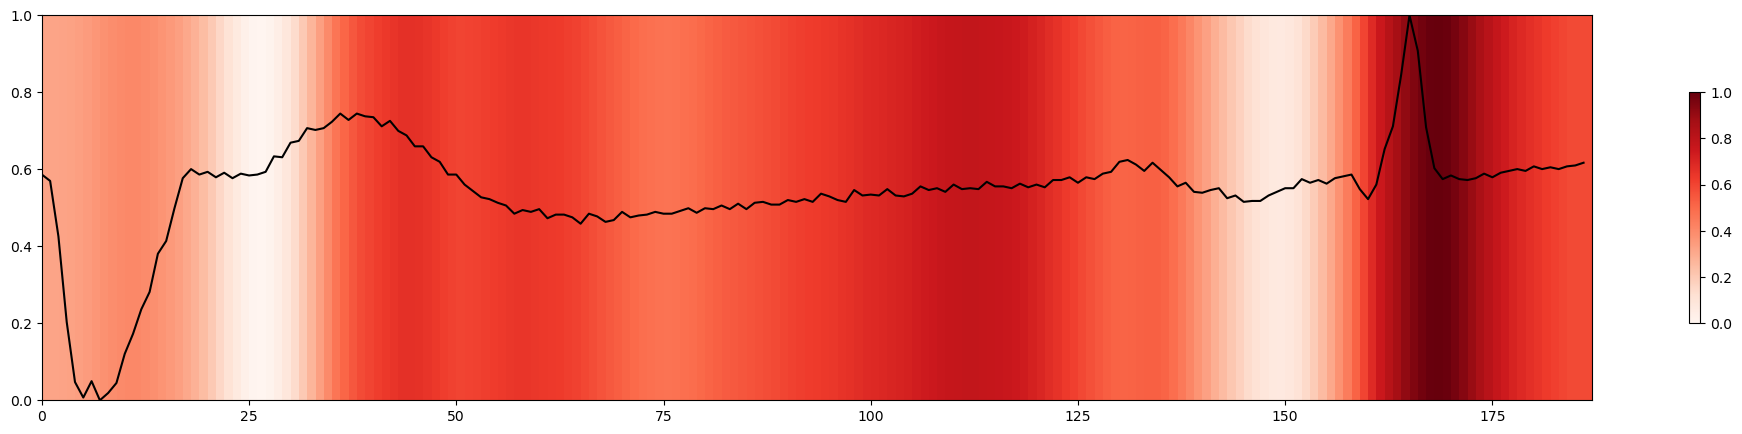

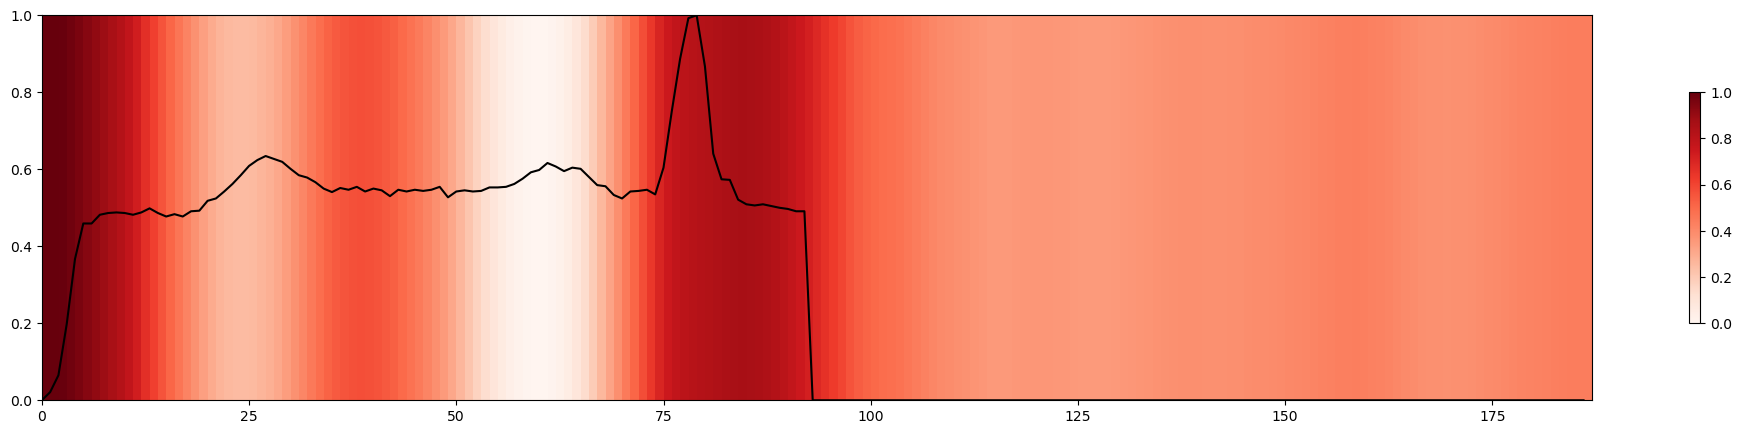

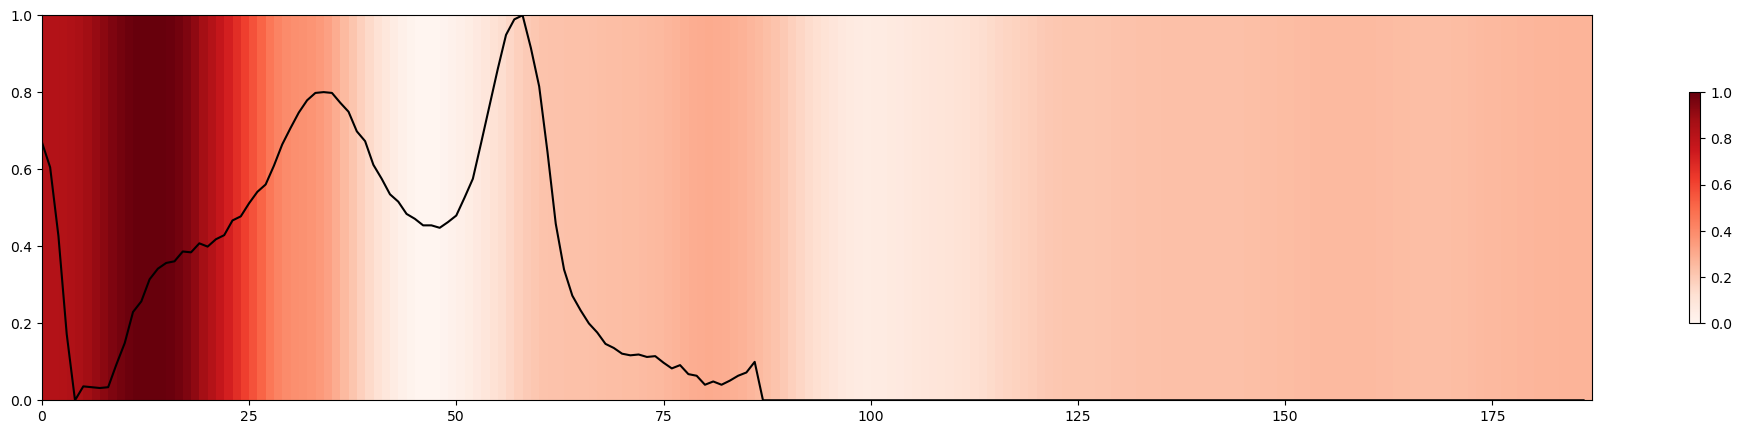

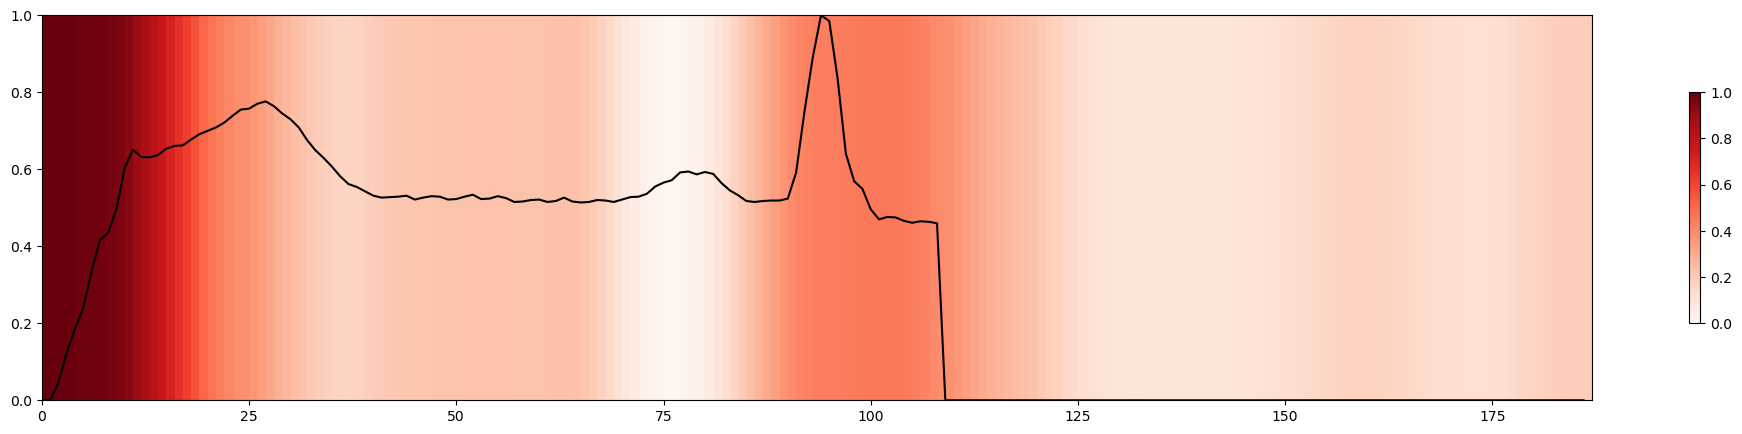

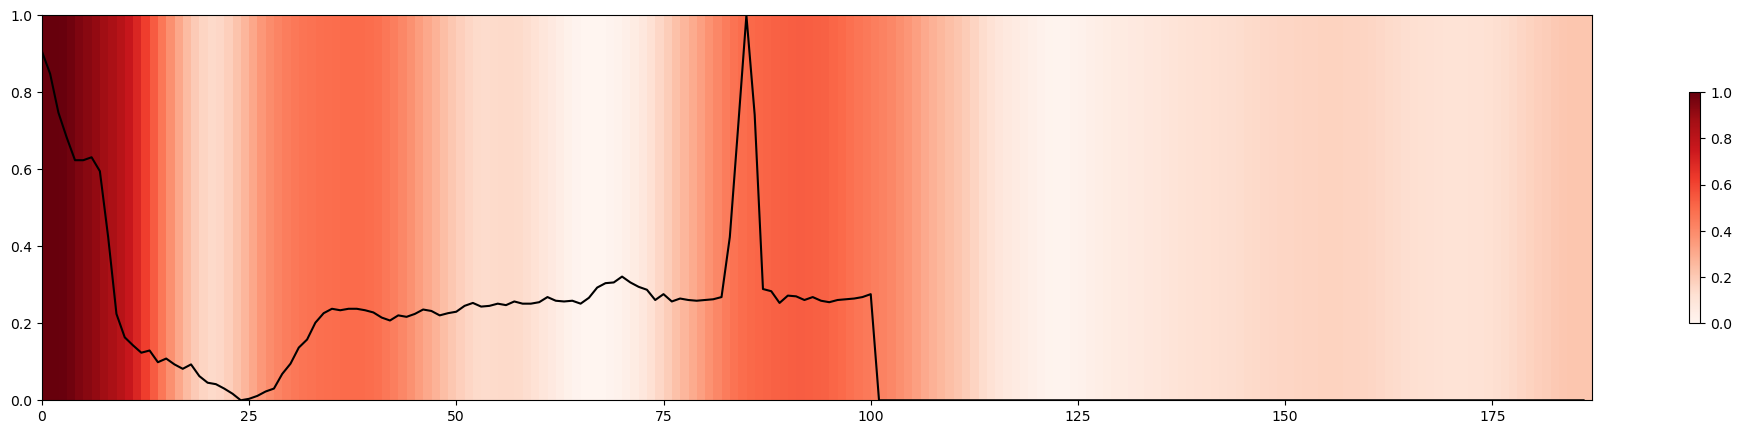

In [14]:
# CAMs that belongs to class V 
for i in range(19000,19005):
  get_prediction(i)

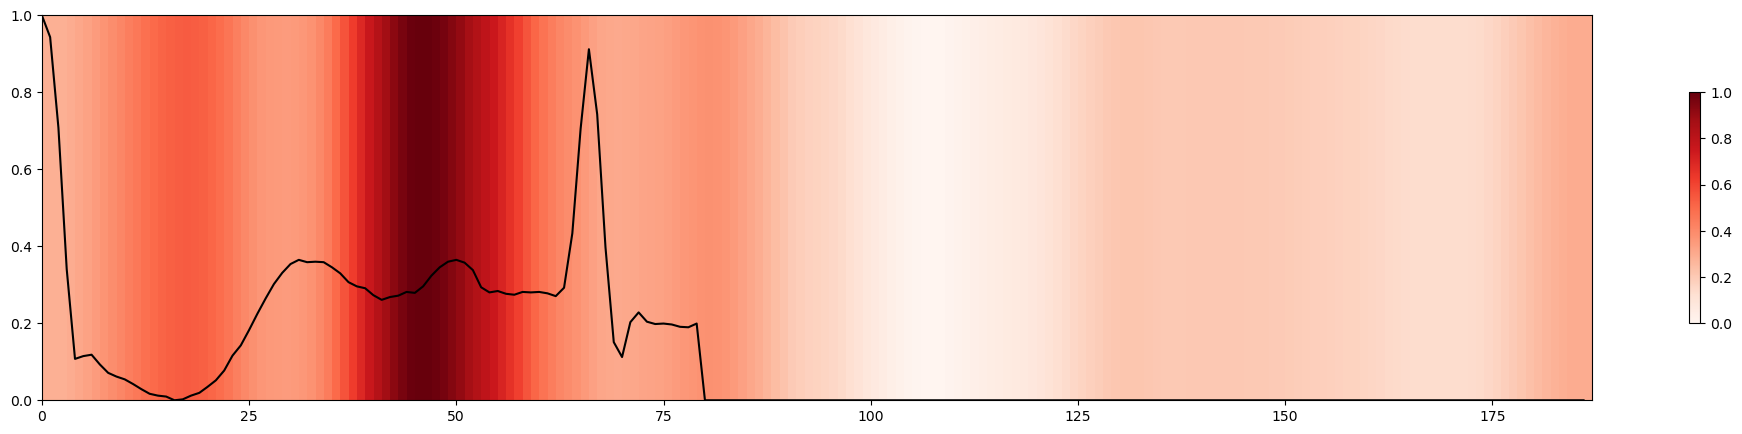

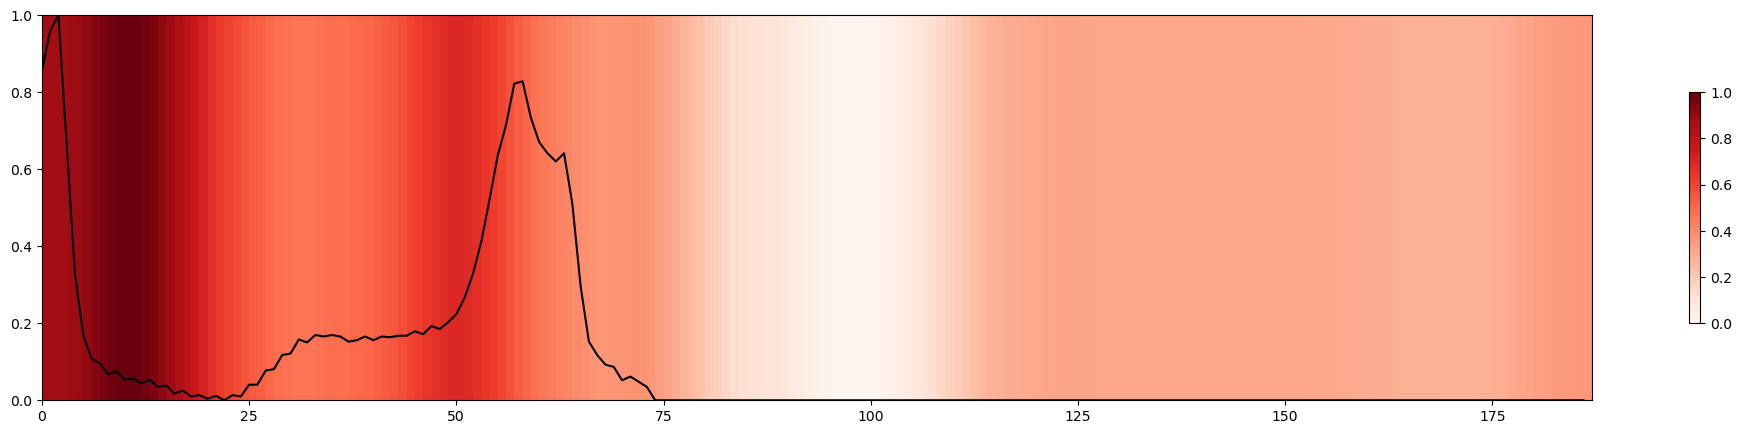

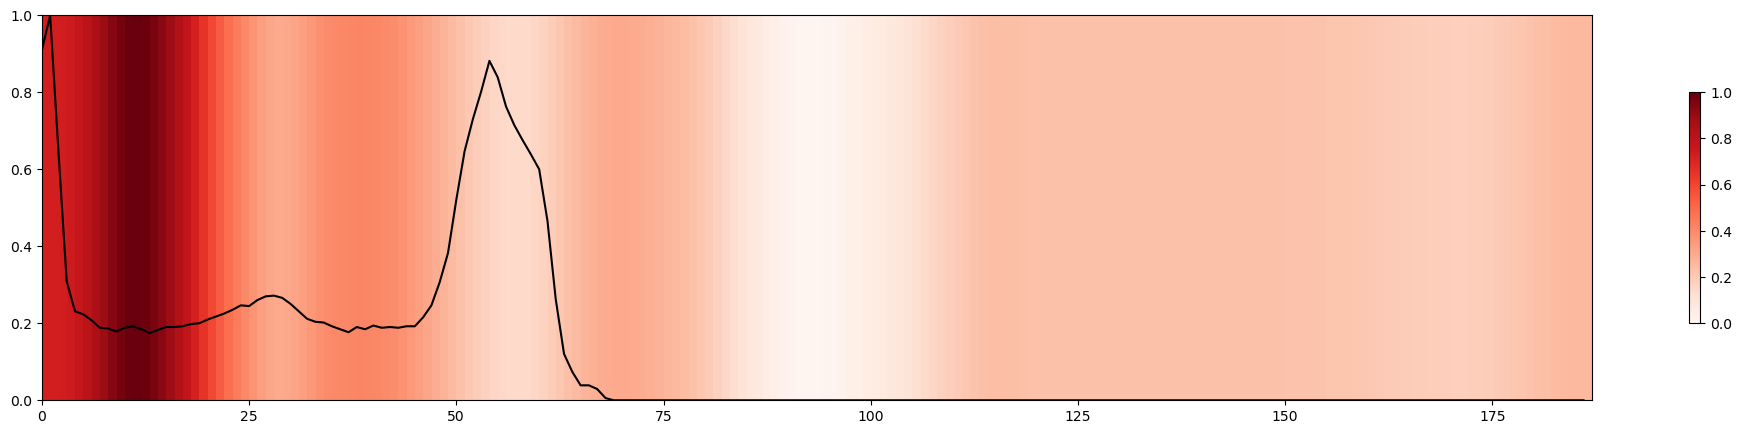

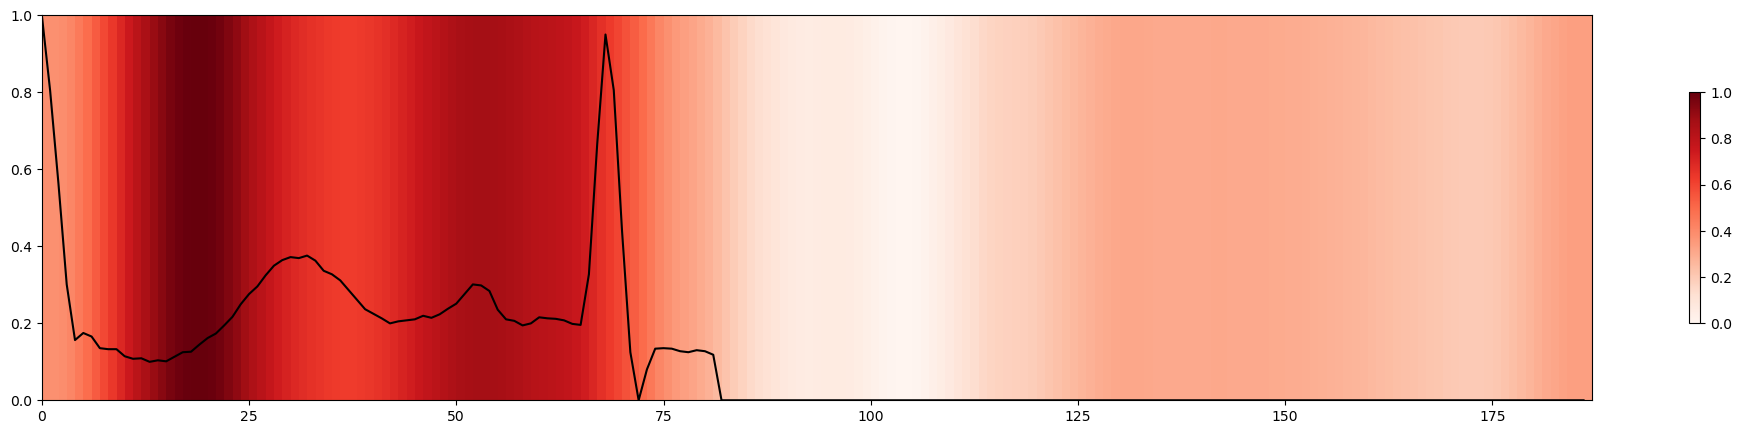

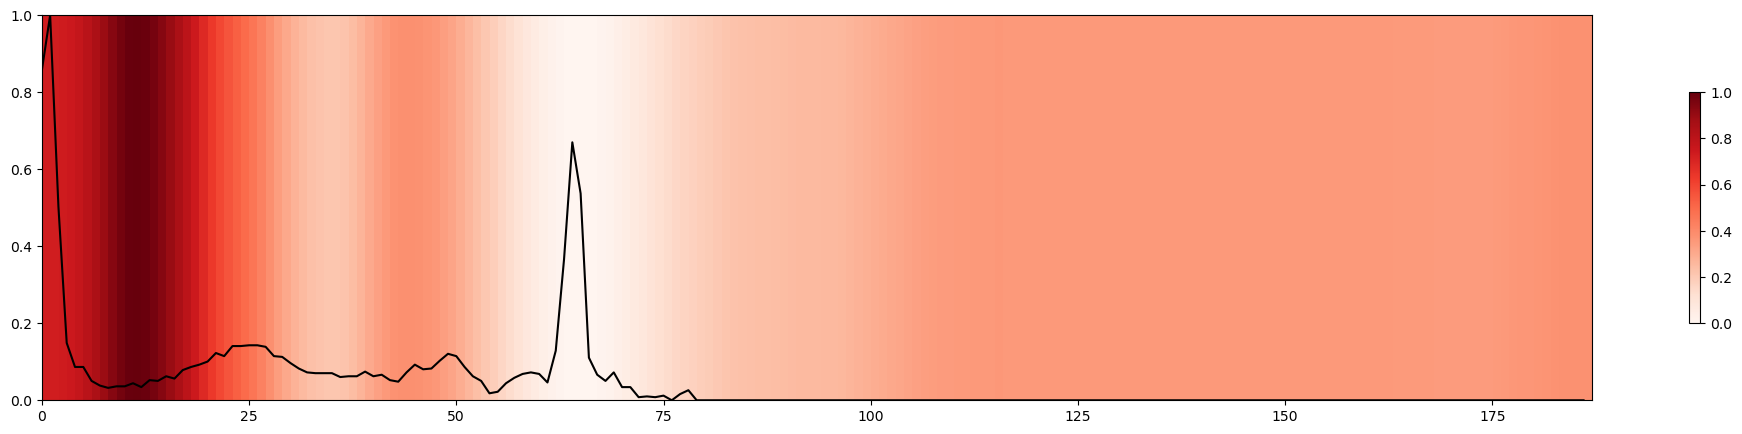

In [15]:
# CAMs that belongs to class F 
for i in range(20150,20155):
  get_prediction(i)

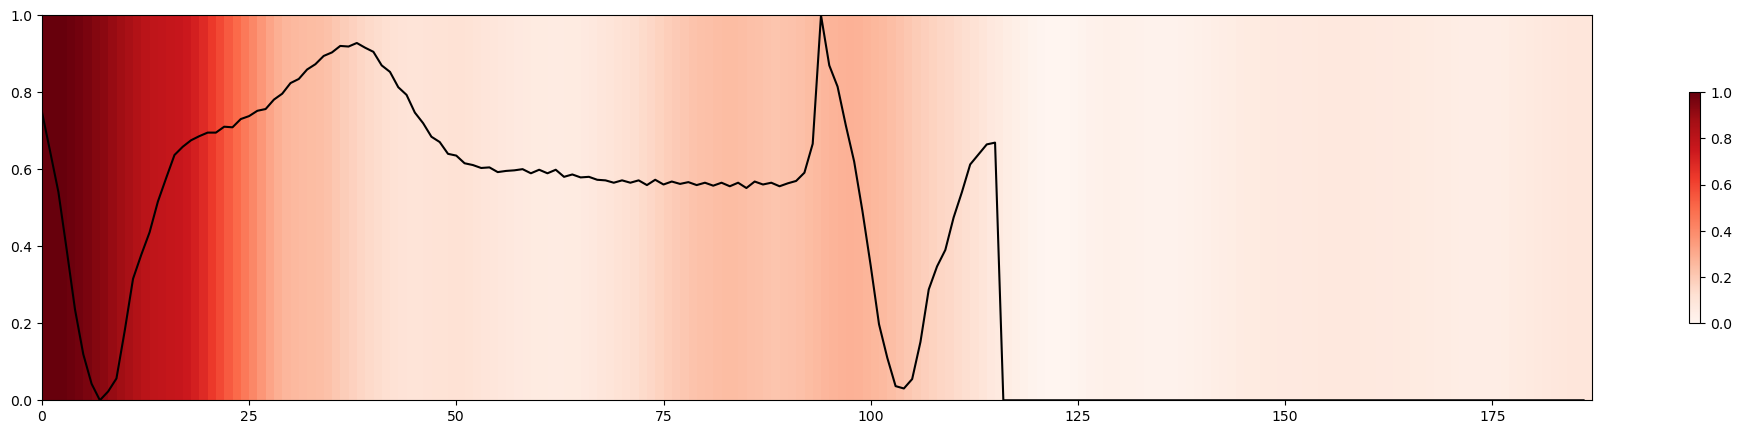

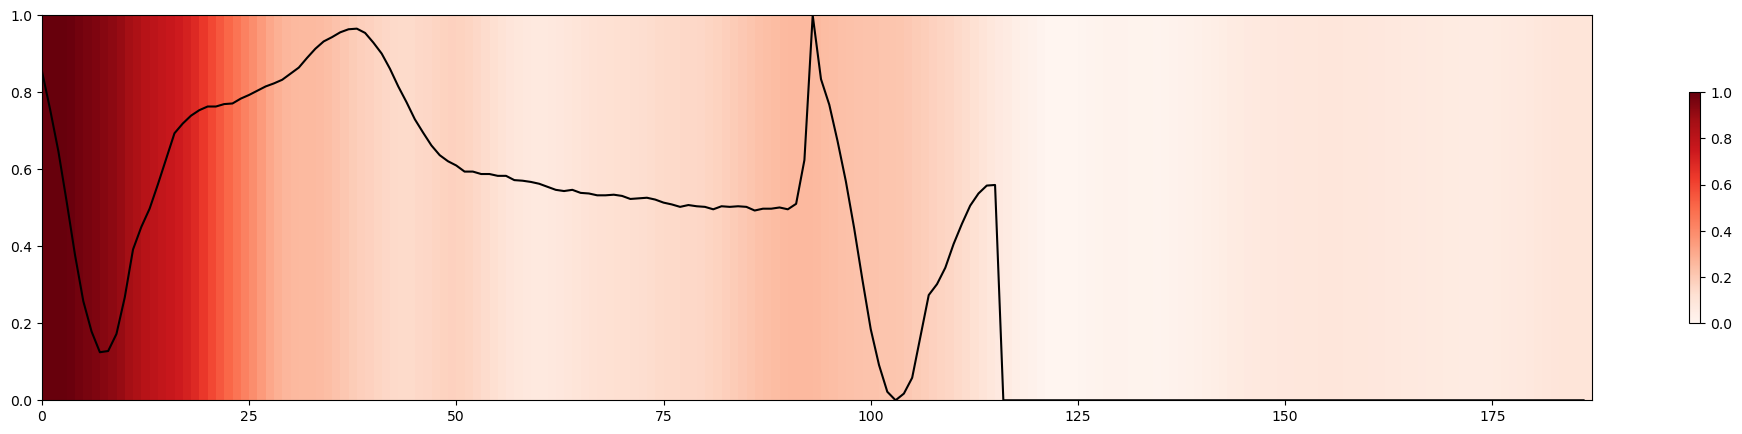

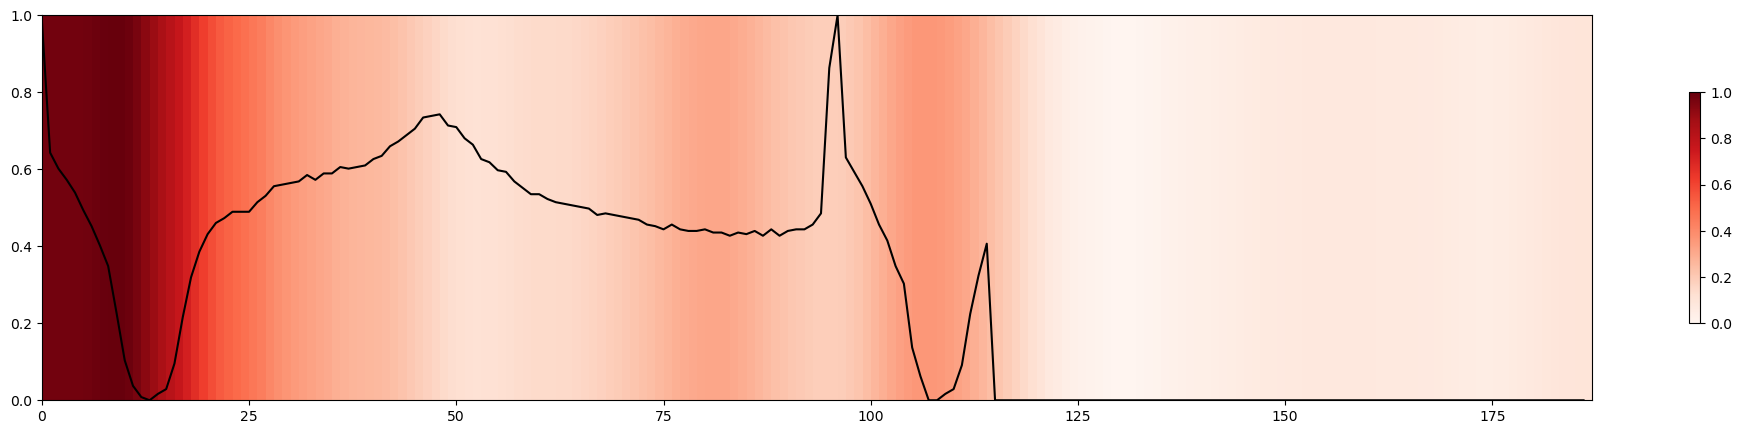

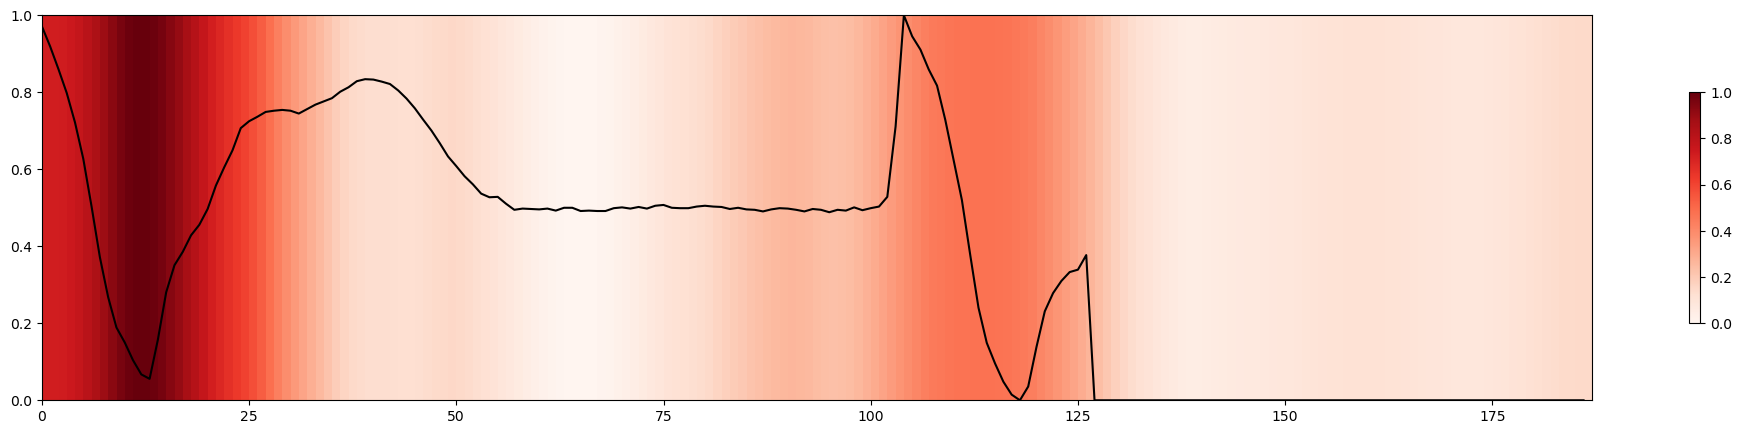

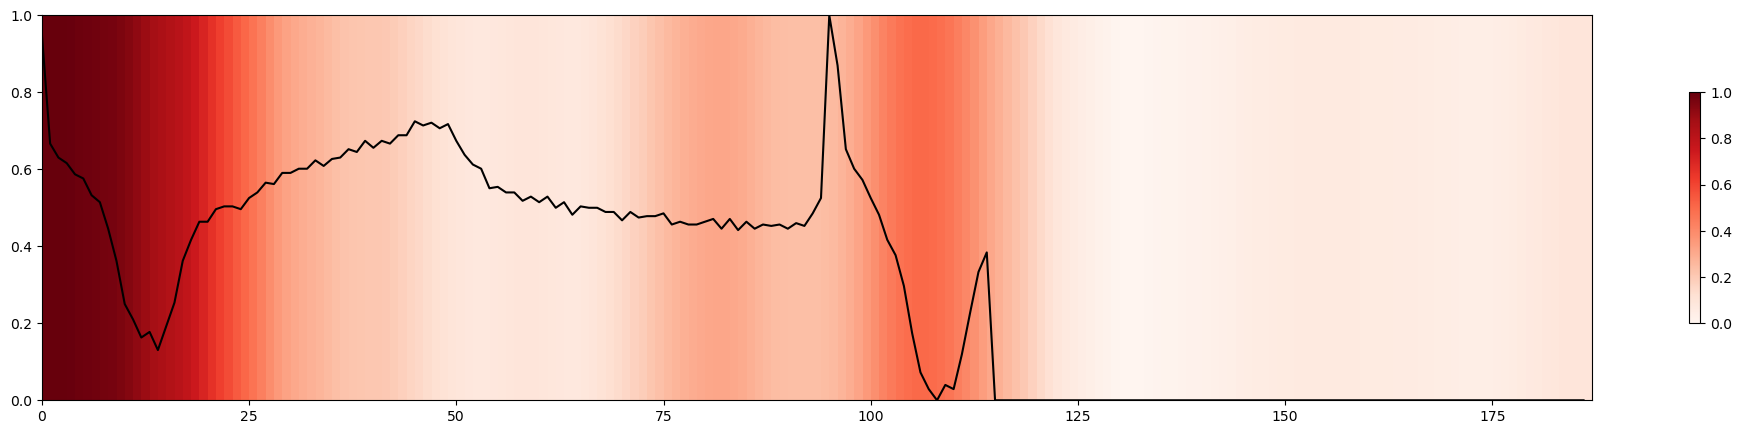

In [16]:
# CAMs that belongs to class Q
for i in range(21800,21805):
  get_prediction(i)

Let's try to generate more examples from data in a DataLoader. We generate the CAMs of a batch of signals.

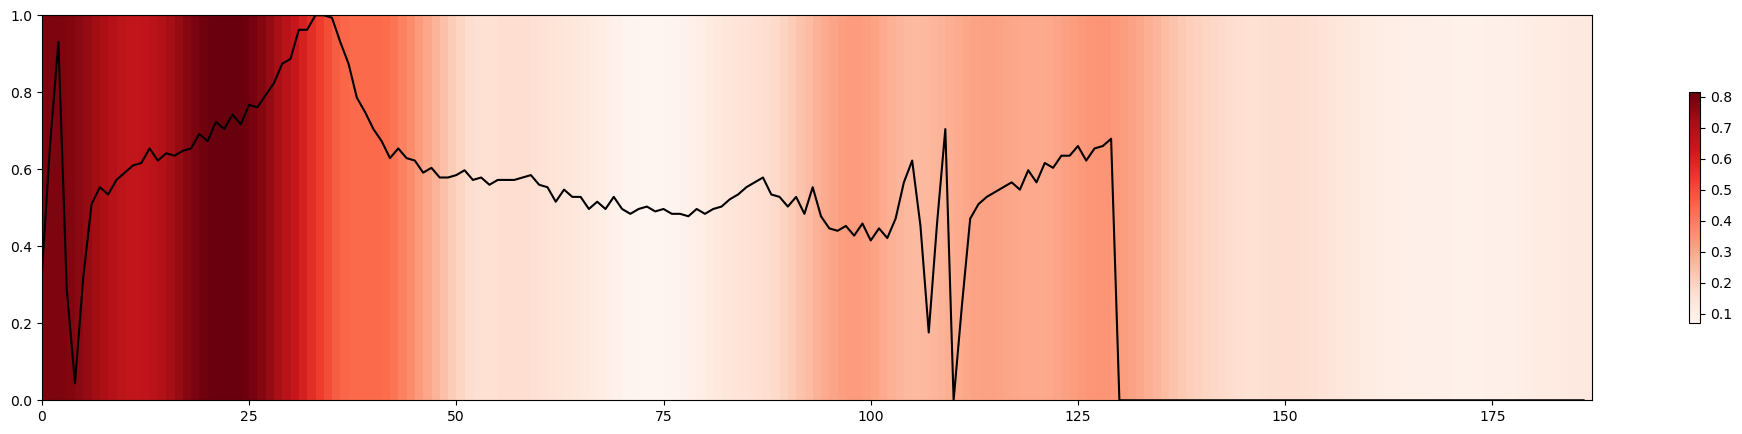

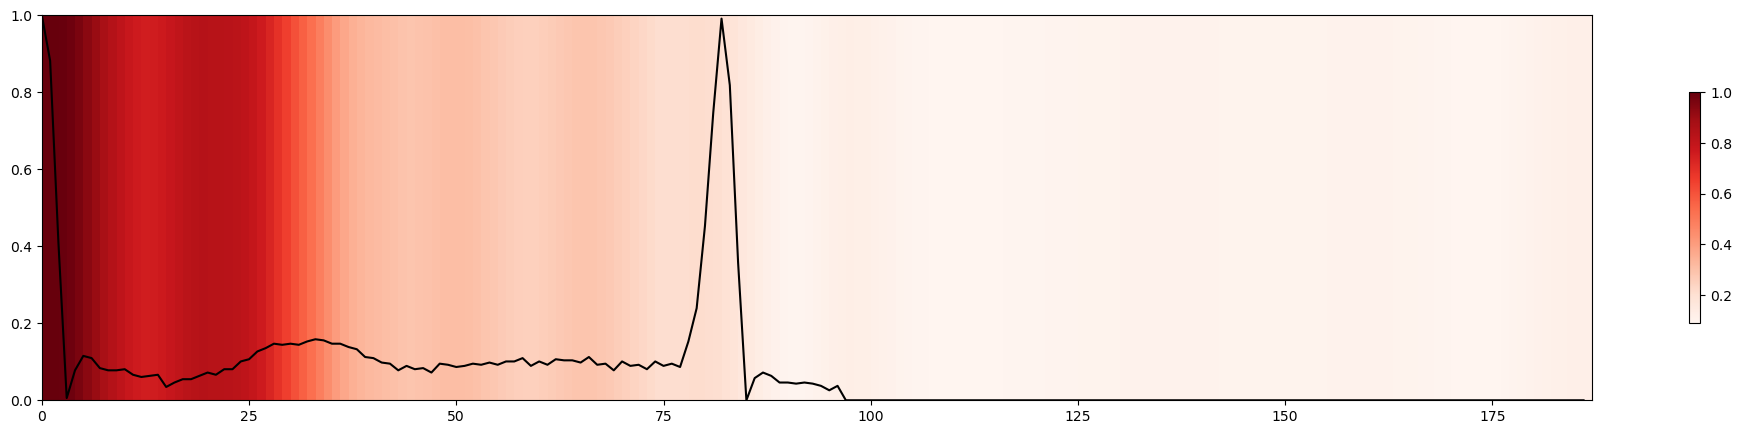

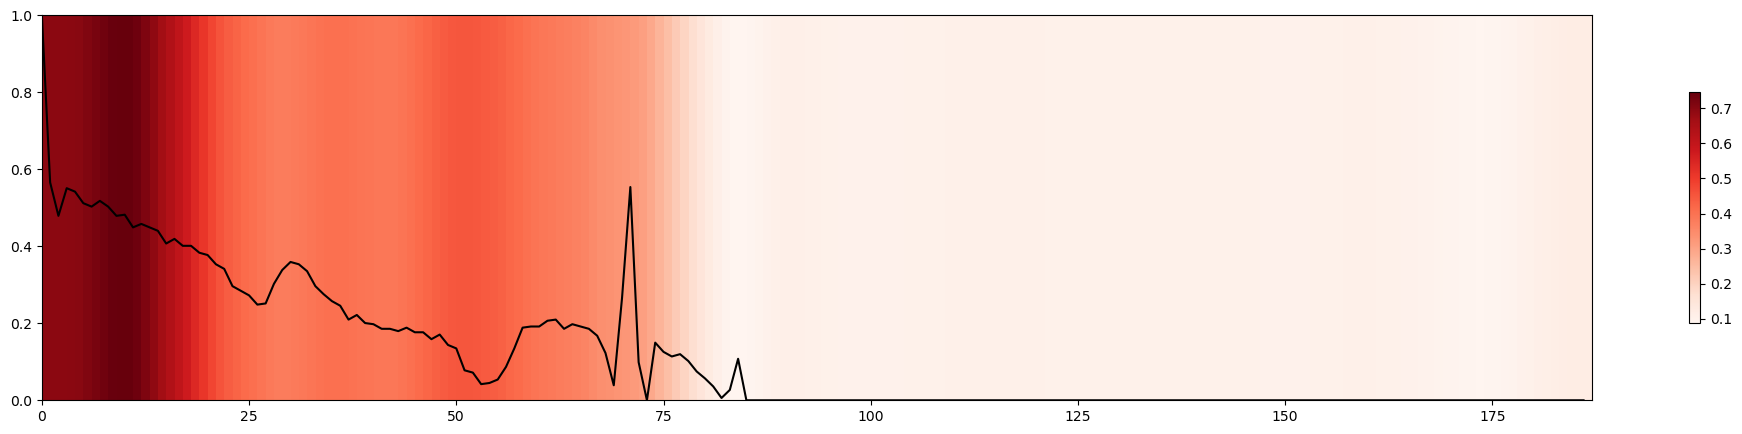

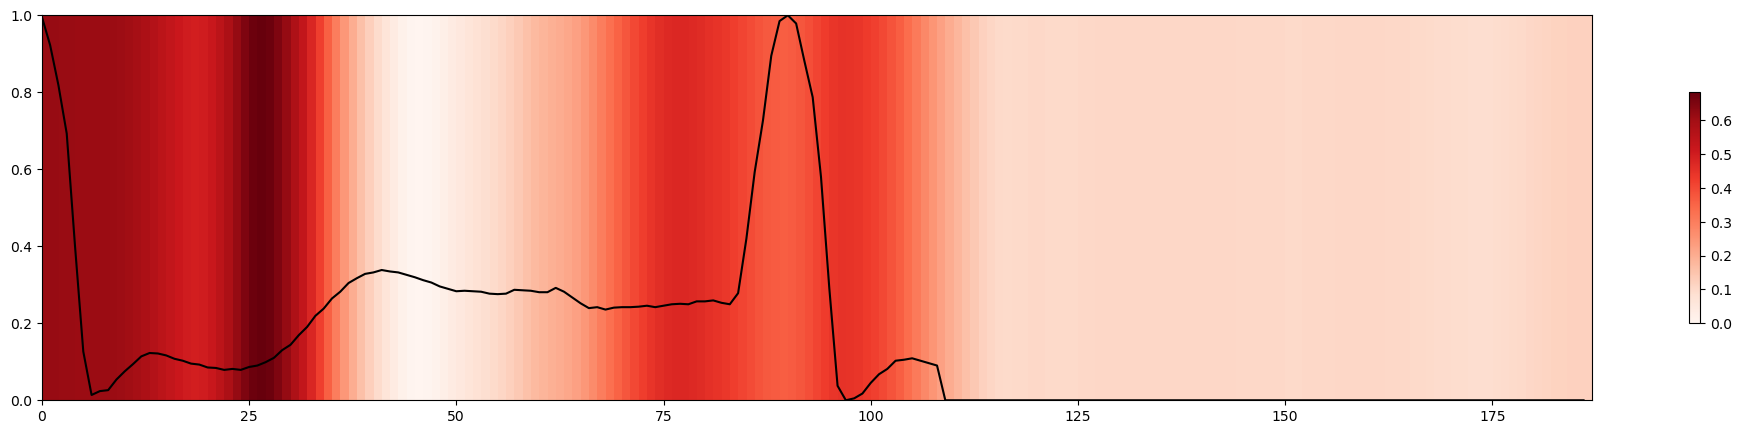

In [17]:
loader = DataLoader(ecg, batch_size=4, shuffle=True, num_workers=2)

for data in loader:

    signal = data[0]
    label = data[1]

    cam, logits = return_cam(model, signal.to(device), label)
    cam = t2n(cam)

    cam_resized = cv2.resize(cam, (signal.shape[-1], cam.shape[0]), interpolation=cv2.INTER_CUBIC)
    cam_normalized = normalize_scoremap(cam_resized)  

    plot_cam(cam_normalized[0:1, :], signal[0])
    plot_cam(cam_normalized[1:2, :], signal[1])
    plot_cam(cam_normalized[2:3, :], signal[2])
    plot_cam(cam_normalized[3:4, :], signal[3])

    break

## Grad-CAM vs CAM

Grad-CAM and CAM are closely related methods in the field of computer vision, particularly in the context of convolutional neural networks (CNNs). Both techniques are designed to provide visual explanations for the decisions made by CNNs, highlighting which parts of an input image are most important for a model's classification decision. However, there are key differences between the two:

1. **Requirement of a GAP Layer**: 
   - CAM requires the presence of a GAP layer in the network architecture. This is because CAM utilizes the weights of the GAP layer to generate class activation maps, which are essentially heatmaps that indicate the important regions in the image for a particular class prediction.
   - Grad-CAM, on the other hand, does not require a GAP layer. It is more flexible and can be applied to a wider range of CNN architectures. Grad-CAM uses the gradient information flowing into the last convolutional layer of the CNN to understand which regions in the image were most important for the network's decision.

2. **Applicability and Flexibility**: 
   - CAM is limited to specific network architectures that include a GAP layer directly connected to the final classification layer. This limits its applicability to only certain types of CNN models.
   - Grad-CAM is more versatile. It can be applied to any CNN architecture as long as it has a differentiable classification head. This makes Grad-CAM suitable for a broader range of models and applications in computer vision.

For more details on the CAM algorithm, please refer to the original paper [2]

## References

[1] Mohammad Kachuee, Shayan Fazeli, and Majid Sarrafzadeh. "ECG Heartbeat Classification: A Deep Transferable Representation." arXiv preprint arXiv:1805.00794 (2018).

[2] Zhou B, Khosla A, Lapedriza A, et al. Learning Deep Features for Discriminative Localization[C]. The IEEE Conference on Computer Vision and Pattern Recognition (CVPR). 2016: 2921-2929.